# T09: Bootstrap

TA: HUANG Xinrui, HKUST

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

- The __bootstrap__ is a widely applicable and extremely powerful statistical tool that can be used to quantify the __uncertainty__ associated with a given estimator or statistical learning method.
- Frequently used to estimate the standard errors of the parameter estimates, especially when the closed form is difficult to obtain.

Consider a portfolio investment problem. 
- Given two financial assets $X$ and $Y$, where both are __random quantities__ with variance $\sigma_Y^2$, $
\sigma_X^2$ and covariance $\sigma_{XY}$. 
- Suppose we aim to minimize the __variability__ of a investment strategy that is a combination of $X$ and $Y$, i.e.,  $\min_{\alpha} Var(\alpha X + (1-\alpha)Y)$. 
- It is easy to show that the optimal $\alpha$ is obtained by $\alpha=\frac{\sigma_Y^2-\sigma_{XY}}{\sigma_X^2+\sigma_Y^2-2\sigma_{XY}}$.
- In real applications, $\sigma_X^2$, $\sigma_Y^2$ and $\sigma_{XY}$ are unknown, we can estimate these parameters from a dataset and hence obtain the estimate of $\alpha$: $$\hat{\alpha}=\frac{\hat{\sigma}_Y^2-\hat{\sigma}_{XY}}{\hat{\sigma}_X^2+\hat{\sigma}_Y^2-2\hat{\sigma}_{XY}}$$
- Here we generate simulation data by setting $\sigma_X^2=1$, $\sigma_Y^2=1.25$ and $\sigma_{XY}=0.5$. Then the ground truth is $\alpha=0.6$.
- If we sample $n$ potins of $(X,Y)$ to estimate $\alpha$ and repeat this procedure $m$ times, then we can compute the standard error of $\hat{\alpha}$ from the $m$ estimates: $$\sqrt{\frac{1}{m-1}\sum_{i=1}^m(\hat{\alpha}_i-\frac{1}{m}\sum_{i=1}^m\hat{\alpha}_i)}$$
where $\hat{\alpha}_i$ is the estimate of $\alpha$ using the $i$-th dataset sampled form the population.

In [2]:
np.random.seed(20231024)

n = 200 # Sample size
m = 1000 # Number of simulations

sigmaX = 1
sigmaY = 1.25
sigmaXY = 0.5
sigMat = np.array([[sigmaX, sigmaXY], [sigmaXY, sigmaY]])

alpha = np.zeros(m)
for i in range(m):
    returns = multivariate_normal(mean=np.zeros(2), cov=sigMat).rvs(n)
    X = returns[:,0]
    Y = returns[:,1]
    alpha[i] = (np.var(Y) - np.cov(X,Y)[0,1]) / (np.var(X) + np.var(Y) - 2 * np.cov(X,Y)[0,1])

print("Mean of alpha:", np.mean(alpha))
print("Standard deviation of alpha:", np.std(alpha))

Mean of alpha: 0.5980558955514177
Standard deviation of alpha: 0.05563449823636808


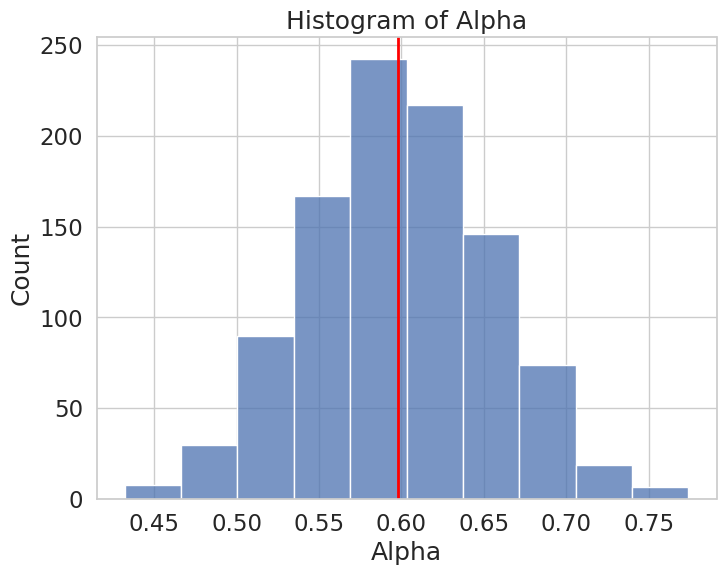

In [3]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
ax = sns.histplot(alpha, bins=10)
ax.axvline(x=np.mean(alpha), color='red', linewidth=2)
ax.set(xlabel='Alpha', ylabel='Count', title='Histogram of Alpha')
plt.show()

- The mean value of $m$ estimates of $\alpha$ is 0.598.
- The standard error of $\hat{\alpha}$ is 0.056.
- The practical issue is that __we cannot sample from the ground truth given a real dataset__.
- __Bootstrap__: we instead obtain distinct data sets by repeatedly sampling observations from the __original data set__. That says the standard error of $\hat{\alpha}$ is estimated by
$$\sqrt{\frac{1}{B-1}\sum_{i=1}^B(\hat{\alpha}^*_i-\frac{1}{B}\sum_{i=1}^B\hat{\alpha}^*_i)}$$
where $\hat{\alpha}^*_i$ is the estimate of $\alpha$ using the $i$-th dataset sampled from the original dataset.

In [4]:
np.random.seed(20231024)

n = 200 # Sample size
B = 1000 # Number of bootstrap samples

sigmaX = 1
sigmaY = 1.25
sigmaXY = 0.5
sigMat = np.array([[sigmaX, sigmaXY], [sigmaXY, sigmaY]])

returns = multivariate_normal(mean=np.zeros(2), cov=sigMat).rvs(n)

alpha_bootstrap = np.zeros(B)
for i in range(B): 
    returns_i = returns[np.random.choice(np.arange(n), n, replace=True), :]
    X = returns_i[:, 0]
    Y = returns_i[:, 1]
    alpha_bootstrap[i] = (np.var(Y) - np.cov(X, Y)[0,1]) / (np.var(X) + np.var(Y) - 2 * np.cov(X, Y)[0,1])

print("Mean of alpha from bootstrap samples:", np.mean(alpha_bootstrap))
print("Standard deviation of alpha from bootstrap samples:", np.std(alpha_bootstrap))

Mean of alpha from bootstrap samples: 0.5901584665863756
Standard deviation of alpha from bootstrap samples: 0.05460373159792068


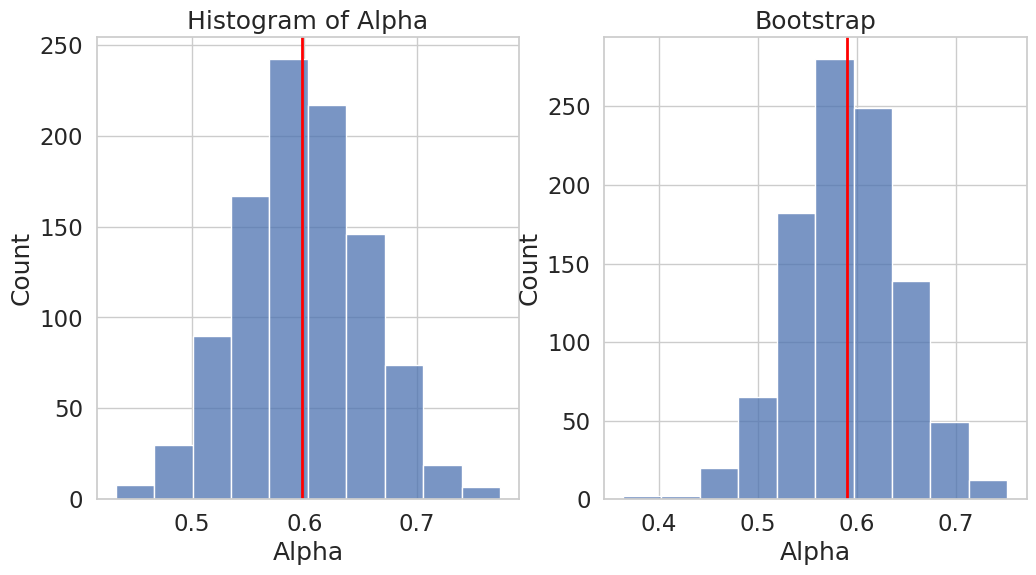

In [5]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
ax = sns.histplot(alpha, bins=10)
ax.axvline(x=np.mean(alpha), color='red', linewidth=2)
ax.set(xlabel='Alpha', ylabel='Count', title='Histogram of Alpha')

plt.subplot(1,2,2)
ax2 = sns.histplot(alpha_bootstrap, bins=10)
ax2.axvline(x=np.mean(alpha_bootstrap), color='red', linewidth=2)
ax2.set(xlabel='Alpha', ylabel='Count', title='Bootstrap')

plt.show()

- The mean value of $B$ bootstrap estimates of $\alpha$ is 0.59.
- The bootstrap standard error of $\hat{\alpha}$ is 0.055.
- These quantities are very close to the ones obtained by sampling from the population.
- __Note: we only use bootstrap to estimate the standard error of $\hat{\alpha}$, the estimate of $\alpha$ should be be computed using the whole dastaset as what we did before.__